**IMPORTING MY LIBRARIES**

In [1]:
import warnings
import pandas as pd               
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import  mean_absolute_error, mean_squared_error,  r2_score
import missingno as msno
from sklearn.pipeline import make_pipeline
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import  train_test_split
warnings.simplefilter(action="ignore", category=FutureWarning)
from glob import glob


**1. For this project, we want to build a model for apartments in Buenos Aires proper ("Capital Federal") that cost less than $400,000. Looking at the first five rows of our DataFrame, we can already see that there properties that fall outside those parameters. So our first cleaning task is to remove those observations from our dataset. Since we're using a function to import and clean our data, we'll need to make changes there.**



**2. Remove outliers by trimming the bottom and top 10% of properties in terms of "surface_covered_in_m2".**

**3. Create separate "lat" and "lon" columns.**

**4. Buenos Aires is divided into 54 boroughs. Create a "borough" feature from the "place_with_parent_names" column.**

**5. Drop columns that are more than 50% null values.**

**6. Drop columns containing low- or high-cardinality categorical values.**

**7. Drop any columns that would constitute leakage for the target "price_aprox_usd".**

**8. Drop any columns that would create issues of multicollinearity.**

**top 5 proportional chart of "property_type" and "place_with_parent_names" distribution**

**CREATING A WRANGLE FUNCTION**

In [72]:

def wrangle(filepath):
    # Read CSV file
    df = pd.read_csv(filepath)
# Subset data: Apartments in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_apt = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000
    
    df = df[mask_ba & mask_apt & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns="lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)
 

    # dropping columns with more than 50% NAN files
    percentage_of_data = (df.isna().sum() / len(df) * 100)
    df.drop(columns=['expenses', 'floor','operation',  'currency', 'properati_url'], inplace=True)
    
    
    # drop leaky columns
    df.drop(columns = [ 'price','price_aprox_local_currency','price_per_m2','price_usd_per_m2'], inplace=True)
    
    # drop columns with multy collinearity
    df.drop(columns=['surface_total_in_m2', 'rooms'], inplace=True)
    
    return df


In [73]:
files = glob(r'C:\Users\USER\Desktop\PROJECTS\buenos-aires-real-estate-*.csv')
files


['C:\\Users\\USER\\Desktop\\PROJECTS\\buenos-aires-real-estate-1.csv',
 'C:\\Users\\USER\\Desktop\\PROJECTS\\buenos-aires-real-estate-2.csv',
 'C:\\Users\\USER\\Desktop\\PROJECTS\\buenos-aires-real-estate-3.csv',
 'C:\\Users\\USER\\Desktop\\PROJECTS\\buenos-aires-real-estate-4.csv',
 'C:\\Users\\USER\\Desktop\\PROJECTS\\buenos-aires-real-estate-5.csv']

In [74]:
frames = []
for file in files:
    df = wrangle(file)
    frames.append(df)


In [75]:
df = pd.concat(frames, ignore_index=True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   property_type          6582 non-null   object 
 1   price_aprox_usd        6582 non-null   float64
 2   surface_covered_in_m2  6582 non-null   float64
 3   lat                    6316 non-null   float64
 4   lon                    6316 non-null   float64
 5   neighborhood           6582 non-null   object 
dtypes: float64(4), object(2)
memory usage: 308.7+ KB


,property_type,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
0,apartment,129000.0,70.0,-34.584651,-58.454693,Chacarita
1,apartment,87000.0,42.0,-34.638979,-58.500115,Villa Luro
2,apartment,118000.0,54.0,-34.615847,-58.459957,Caballito
3,apartment,57000.0,42.0,-34.625222,-58.382382,Constitución
4,apartment,90000.0,50.0,-34.610610,-58.412511,Once


**STATISTICS OF THE DATA**

In [76]:
df.describe()


,price_aprox_usd,surface_covered_in_m2,lat,lon
count,6582.000000,6582.000000,6316.000000,6316.000000
mean,132383.837015,53.655576,-34.598906,-58.437596
std,58743.950211,18.022046,0.026677,0.038580
min,5195.790000,30.000000,-34.817394,-58.543958
25%,89900.000000,39.000000,-34.619432,-58.466410
50%,118625.000000,49.000000,-34.601585,-58.438931
75%,159000.000000,66.000000,-34.578414,-58.408257
max,399000.000000,101.000000,-34.536108,-58.344687


array([[<Axes: title={'center': 'price_aprox_usd'}>,
        <Axes: title={'center': 'surface_covered_in_m2'}>],
       [<Axes: title={'center': 'lat'}>, <Axes: title={'center': 'lon'}>]],
      dtype=object)

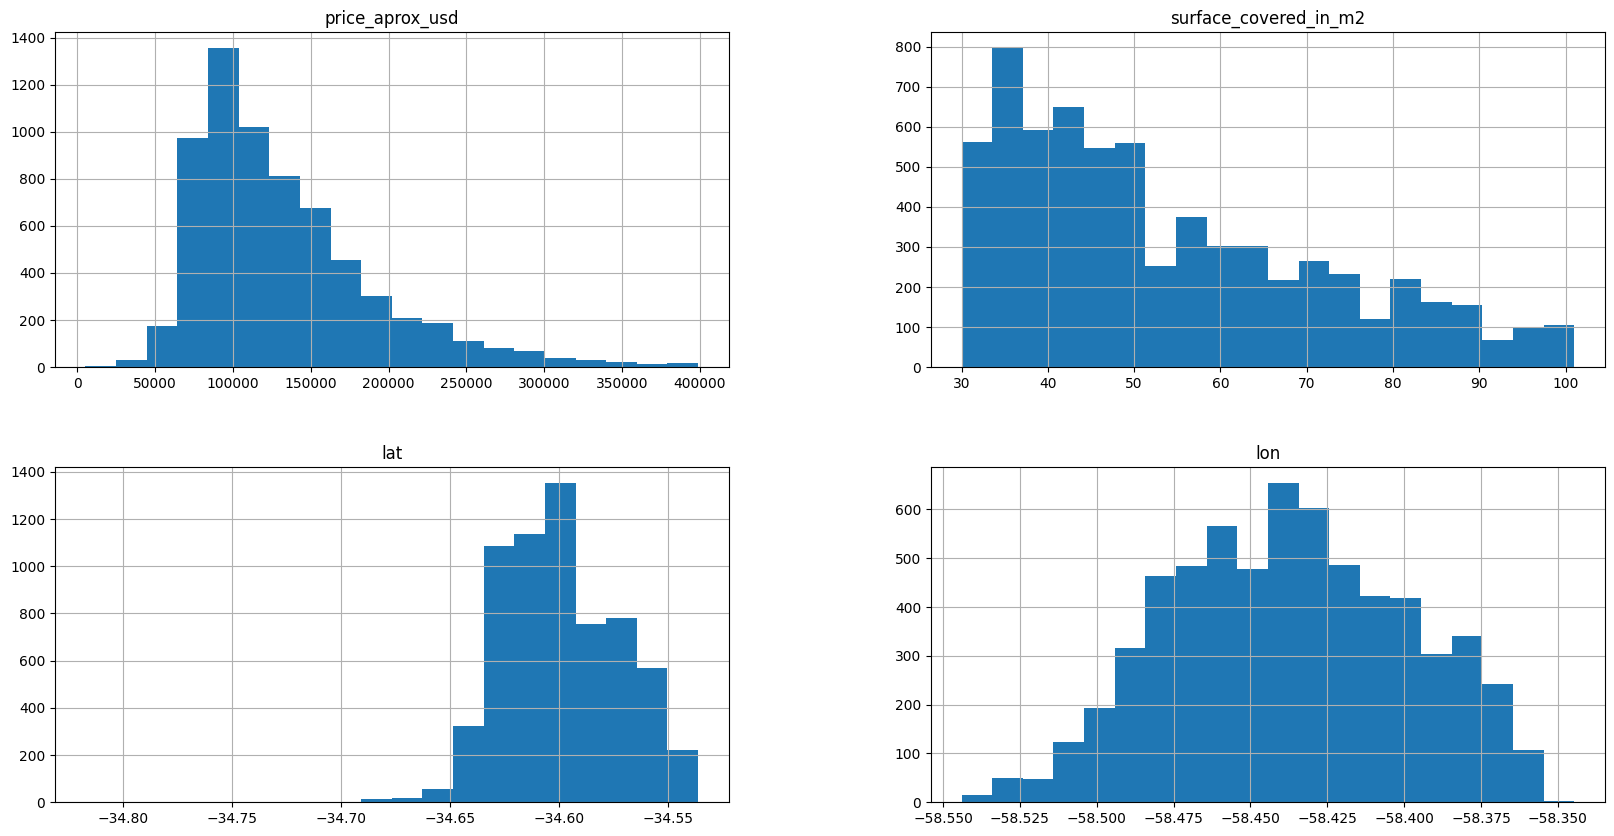

In [77]:
df.hist(figsize=(20,10), bins=20)


**WE CAN SEE THERS A RELATIONSHIP BETWEEN THE SURFACE AREA OF THE APARTMENT AND THE PRICE OF THE APARTMENT**

Text(0.5, 1.0, 'Price_approx_usd vs surface_covered_in_m2')

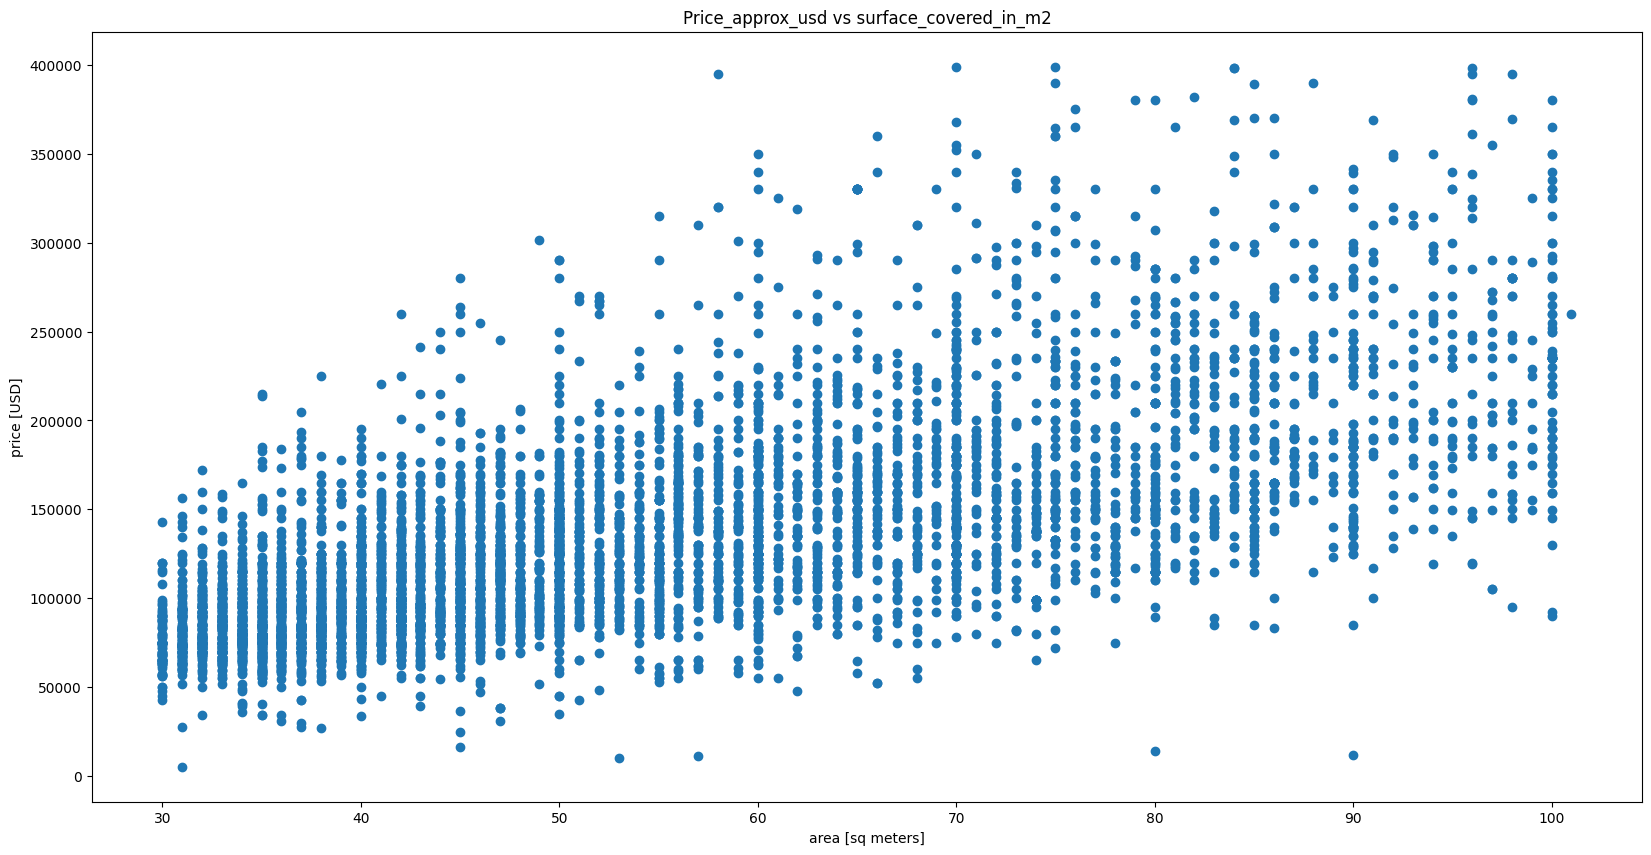

In [78]:
price = df['price_aprox_usd']
area = df['surface_covered_in_m2']
plt.figure(figsize=(20, 10))
plt.scatter(area, price)
plt.xlabel('area [sq meters]')
plt.ylabel('price [USD]')
plt.title('Price_approx_usd vs surface_covered_in_m2')


**WE HAVE SEEN THE PRICE PER APARTMENT AS PER EACH LOCATION USING LATITUDE AND LONGITUDE**

In [79]:
fig = px.scatter_mapbox(
    df,  # Our DataFrame
    lat=df['lat'],
    lon=df['lon'],
    width=1600,  # Width of map
    height=600,  # Height of map
    color=df['property_type'],
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")


**TOP 20 NEIGHBORHOOD WITH THEIR AVERAGE PRICE PER APARTMENT**

Text(0.5, 1.0, 'AVERAGE PRICE OF APARTMENT IN EACH BOROUGH')

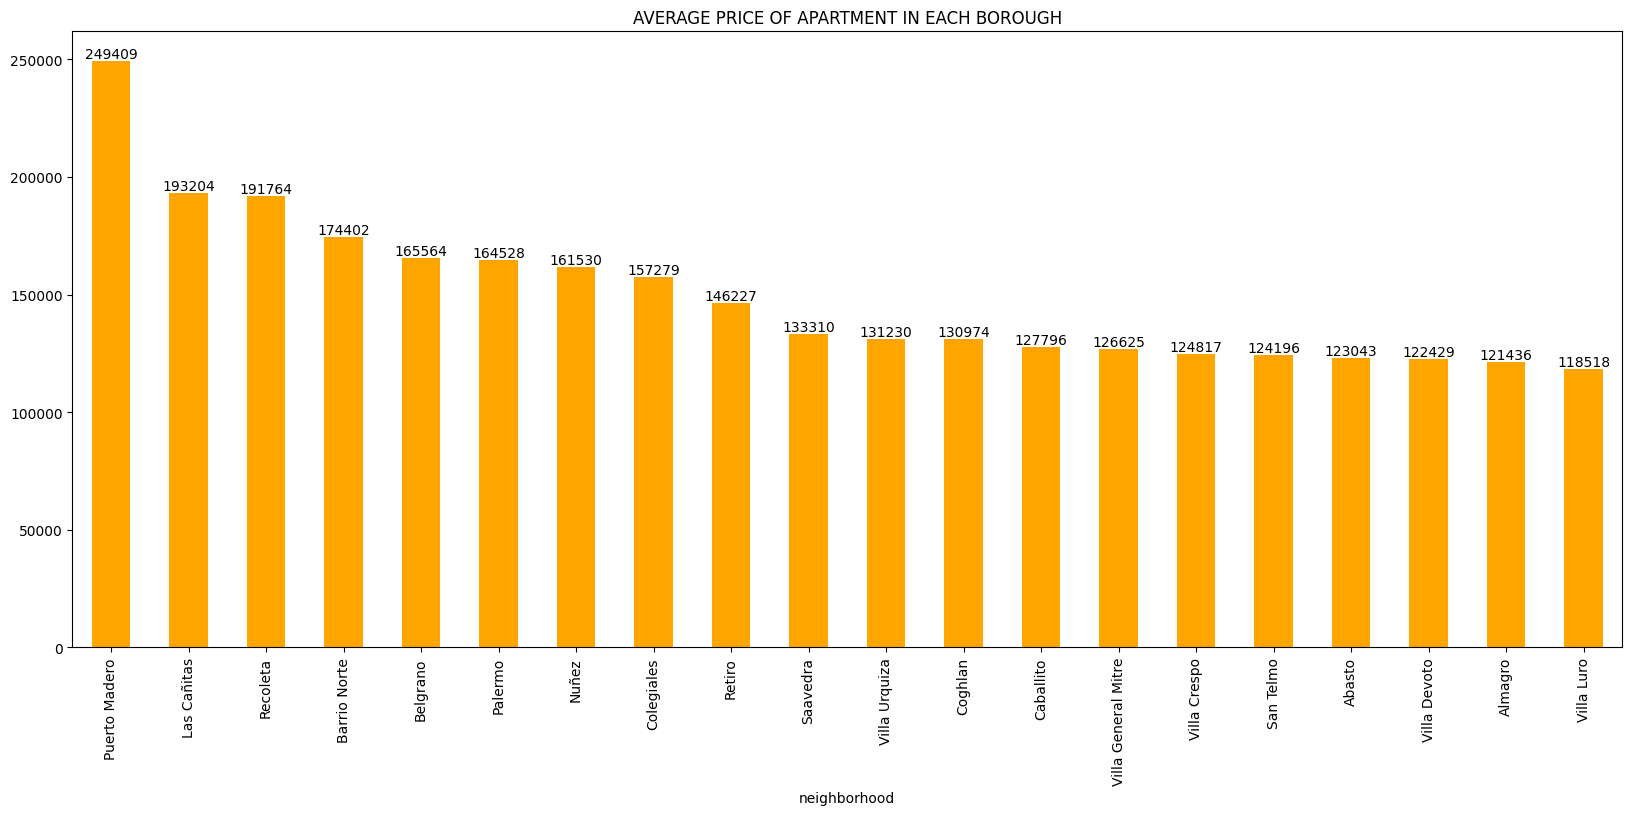

In [80]:
plt.figure(figsize=(20, 8))
graph = df.groupby('neighborhood')['price_aprox_usd'].mean().sort_values(ascending = False)[:20].plot.bar(color='orange')
for x in graph.containers:
    graph.bar_label(x)

plt.title('AVERAGE PRICE OF APARTMENT IN EACH BOROUGH')


In [83]:
print(df['neighborhood'].nunique())
print(df['neighborhood'].unique())


57
['Chacarita' 'Villa Luro' 'Caballito' 'Constitución' 'Once' 'Almagro'
 'Palermo' 'Flores' 'Belgrano' 'Liniers' 'Villa Crespo' 'San Cristobal'
 'Congreso' 'Saavedra' 'Balvanera' 'Parque Avellaneda' 'Recoleta'
 'San Telmo' 'Nuñez' 'Barrio Norte' 'Parque Centenario' 'Abasto'
 'Centro / Microcentro' '' 'Paternal' 'Mataderos' 'Villa Lugano' 'Coghlan'
 'Las Cañitas' 'Villa Urquiza' 'Monserrat' 'Villa Pueyrredón'
 'Parque Patricios' 'San Nicolás' 'Villa del Parque' 'Boedo'
 'Parque Chacabuco' 'Barracas' 'Parque Chas' 'Colegiales'
 'Villa General Mitre' 'Villa Ortuzar' 'Villa Devoto' 'Floresta' 'Retiro'
 'Versalles' 'Boca' 'Puerto Madero' 'Agronomía' 'Monte Castro'
 'Tribunales' 'Villa Santa Rita' 'Velez Sarsfield' 'Villa Soldati'
 'Villa Real' 'Pompeya' 'Catalinas']


**TOP 20 NEIGHBORHOOD WITH THE HIGHEST NUMBER OF APARTMENT**

Text(0.5, 1.0, 'NEIGHBORHOOD WITH THE HIGHEST NUMBER OF APARTMENT')

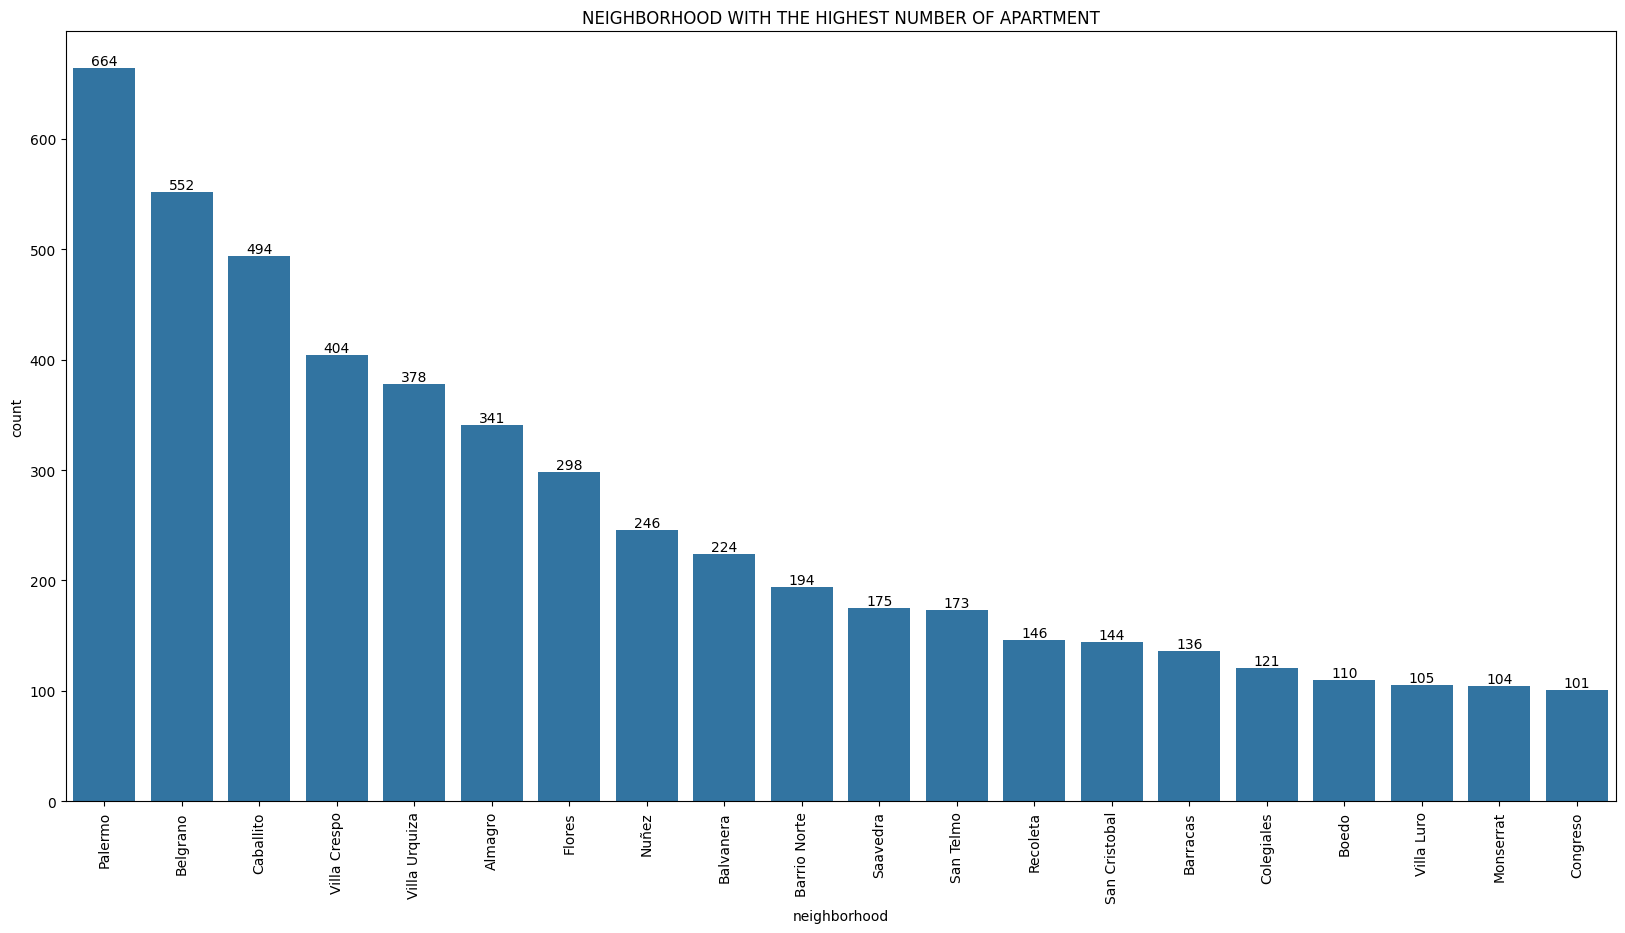

In [84]:
plt.figure(figsize=(20, 10))
graph = sns.countplot(x = 'neighborhood', data = df, order = df['neighborhood'].value_counts(ascending=False).index[:20])
for x in graph.containers:
    graph.bar_label(x)
plt.xticks(rotation=90)
plt.title('NEIGHBORHOOD WITH THE HIGHEST NUMBER OF APARTMENT')


**DROPPING OF UNWANTED COLUMN**

In [85]:
df.drop(columns=['property_type'], inplace=True)   # dropping the "property_type column as it is not important for model prediction "
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6582 non-null   float64
 1   surface_covered_in_m2  6582 non-null   float64
 2   lat                    6316 non-null   float64
 3   lon                    6316 non-null   float64
 4   neighborhood           6582 non-null   object 
dtypes: float64(4), object(1)
memory usage: 257.2+ KB


**SPLITTING OUR DATA SET FOR MODEL TRAINING**

In [86]:
features = ['surface_covered_in_m2', 'lat','lon','neighborhood']
X_train = df[features]
print(X_train.shape)


target = 'price_aprox_usd'
y_train = df[target]
print(y_train.shape)


(6582, 4)
(6582,)


**GETTING THE AVERAGE PRICE OF ALL THE APARTMENT**

In [29]:
y_mean = y_train.mean()  # average price of each apartment 
y_mean


132383.83701458524

**OUR Y_PRED BASELINE PUT OUR AVERAGE PRICE AT 132K OF EVERY AREA**

In [87]:
y_pred_baseline = [y_mean] * len(y_train)  # multiplying it to all our target rows
y_pred_baseline[:5]


[132383.83701458524,
 132383.83701458524,
 132383.83701458524,
 132383.83701458524,
 132383.83701458524]

**SHOWING THE Y_PRED_BASELINE....THIS IS SHOWING THE AVERAGE PRICE OF APARTMENTS PER SURFACE AREA**

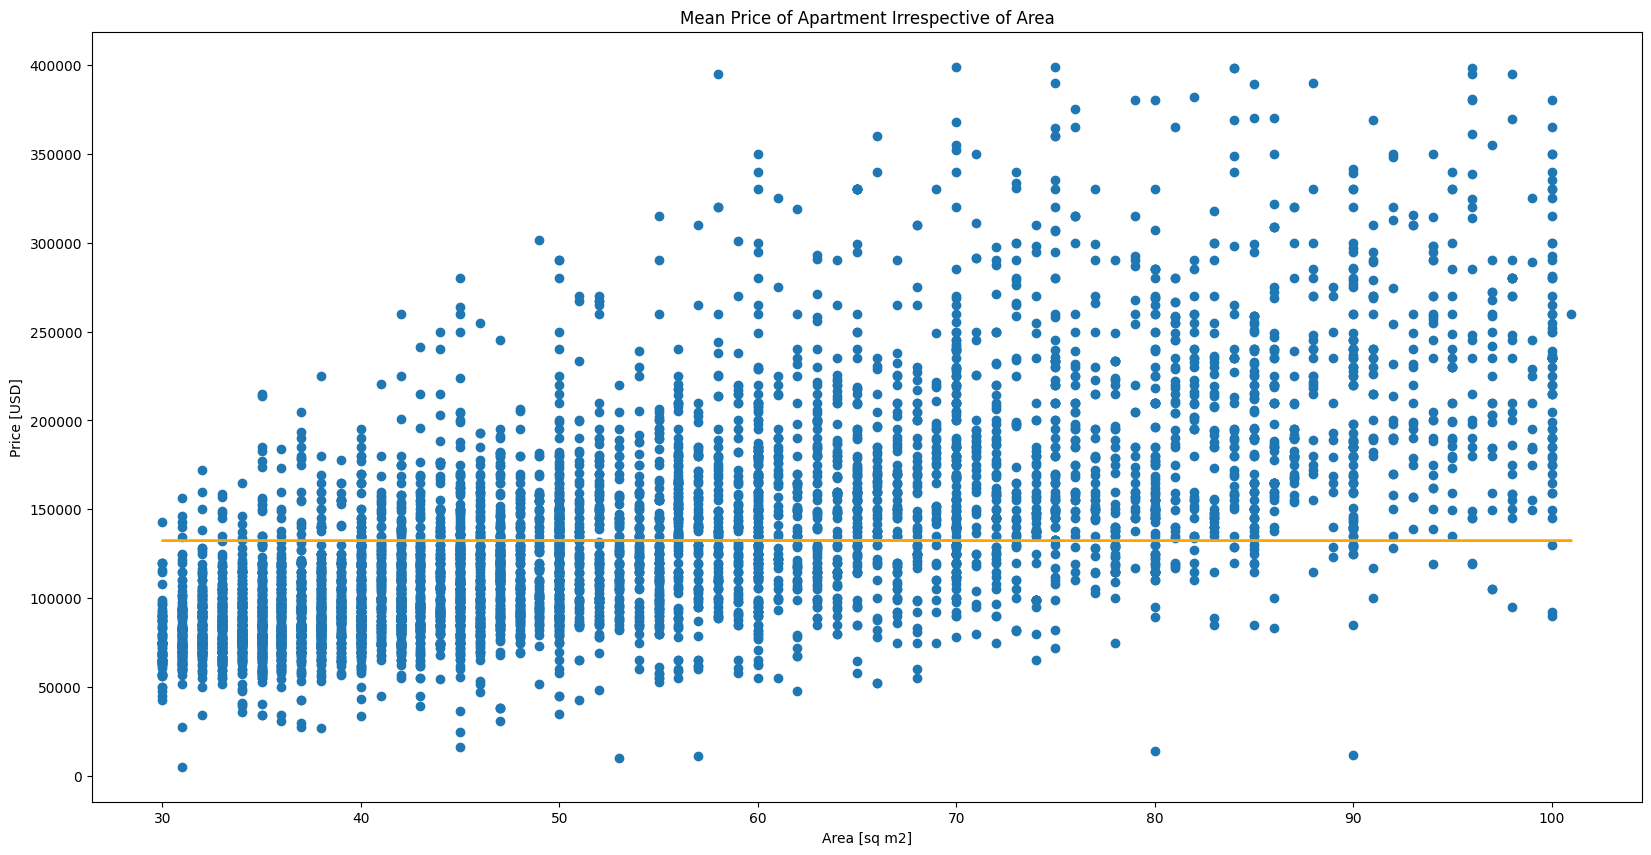

In [88]:
plt.figure(figsize=(20, 10))
plt.plot(df['surface_covered_in_m2'], y_pred_baseline, color='orange')     # the yellow line shows where our average price is per surface area before other features comes into play
plt.scatter(area, price)
plt.xlabel('Area [sq m2]')
plt.ylabel('Price [USD]')
plt.title('Mean Price of Apartment Irrespective of Area')
plt.show()


**MEAN ABSOLUTE ERROR BASELINE**

In [31]:
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print('the mean apartment price :', y_mean)
print('the baseline for mae:',  mae_baseline)


the mean apartment price : 132383.83701458524
the baseline for mae: 44860.10834274133


**BUILDING THE MODEL**

In [54]:
model = make_pipeline(
       OneHotEncoder(),
       SimpleImputer(),
       LinearRegression()
)
model.fit(X_train, y_train)


Pipeline(steps=[('onehotencoder', OneHotEncoder()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

In [55]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6582 entries, 0 to 6581
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   surface_covered_in_m2  6582 non-null   float64
 1   lat                    6316 non-null   float64
 2   lon                    6316 non-null   float64
 3   neighborhood           6582 non-null   object 
dtypes: float64(3), object(1)
memory usage: 205.8+ KB


**THIS MEAN ABSOLUTE ERROR TESTING MEANS MY MODEL IS PERFORMING BETTER THAN THE BASELINE REDUCING ERROR**

In [92]:
y_pred_training = model.predict(X_train)
training_mae = mean_absolute_error(y_train, y_pred_training)

print("Training Mean Absolute Error:", training_mae)



Training Mean Absolute Error: 4330.443765700298


**GETTING THE COEFFICIET AND INTERCEPT**

In [93]:
coefficients = model.named_steps['linearregression'].coef_.round(2)  #for every increase in one unit of the independent variable the depedent variable increases by this value
intercept = model.named_steps['linearregression'].intercept_.round(2)  # where the line of best fit crosses on the dependent variable

print('the coefficient :', coefficients)
print('the intercept :', intercept)


the coefficient : [-89200.4  -87887.69 -84523.82 ... -44930.63   3786.98   9232.04]
the intercept : 150000.89


**PREDICTING WITH A NEW DATA**

In [91]:
def make_prediction(area, lat, lon, neighborhood):
    data = {
        'surface_covered_in_m2': area,
        'lat' : lat,
        'lon' : lon,
        'neighborhood': neighborhood
    } 
    
    df = pd.DataFrame(data, index=[0])
    
    prediction = model.predict(df)
    return f"Predicted apartment price: ${prediction}"


**RESULT**

In [101]:
make_prediction(90.0, -34.60, -58.46, "Puerto Madero")


'Predicted apartment price: $[284669.00929105]'